# OSM Contributions by Country

### How do we determine which Country a mapper might be from?
There has been a decent amount of research on this question, and it's a moving target. One reasonable thought (if we ignore humanitarian or paid-editing teams), is that the Country in which a mapper makes the majority of their changesets is perhaps their home. If not their _actual home_, it is still clearly a location they posess knowledge of and continually map. Some of Pascal Neis's tools use this approach, so I will re-create it here roughly. 

Quick Approach: Find the most occuring country that the `min_lat`, `min_lon` point of each of a mapper's changesets falls into.

<hr>

_Note, as of February 21, the most recent data available on the AWS public dataset is is 2/15/2021._

Thanks!

[Jennings Anderson](https://jenningsanderson.com)

In [1]:
import pandas as pd; import geopandas as gpd; import seaborn as sns; import numpy as np
from shapely.geometry import Point;
import fiona, sys, json;
from matplotlib.ticker import FuncFormatter
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Query:

First, extract data form the OSM changesets data on AWS. This relies on the OSM public dataset and a separate "countries_geom" table that has WKT outlines of world countries. 

```sql
-- A user's most frequently edited Country in the past 5 years? 
WITH most_frequent_editing_country AS (
  WITH user_history AS (
     SELECT uid, code FROM changesets
       JOIN country_geoms
         ON ST_Contains(ST_GeometryFromText(geometry_wkt), ST_Point(min_lon, min_lat)) 
      WHERE ("created_at" >= ( (SELECT "max"("created_at") FROM changesets) - INTERVAL '5' YEAR))
  )
  SELECT uid,
         code AS most_edited_country
  FROM (SELECT uid, code, COUNT(*) AS cnt, ROW_NUMBER() OVER (PARTITION BY uid
           ORDER BY  COUNT(*) DESC) AS seqnum FROM user_history GROUP BY  uid, code ) t
  WHERE seqnum = 1
),

-- Calculate "active contributor" stats
active_contributor AS (
  SELECT uid,
         COUNT(id) AS changesets_in_last365,
         COUNT(DISTINCT(date_trunc('day', created_at))) AS editing_days_in_last365, 
         SUM(num_changes) AS total_edits_in_last365, MAX(created_at) AS most_recent_changeset
    FROM changesets
    WHERE created_at >= ( (SELECT MAX(created_at) FROM changesets) - INTERVAL '365' DAY)
    GROUP BY  uid
)
-- Finally, put it all together:         
SELECT changesets.id,
       changesets.uid,
       changesets.user,
       created_at,
       num_changes,
       country,
       code,
       editing_days_in_last365,
       most_edited_country,
       total_edits_in_last365,
       changesets_in_last365
  FROM changesets 
  LEFT JOIN active_contributors ON changesets.uid = active_contributors.uid
  LEFT JOIN most_frequent_editing_country ON most_frequent_editing_country.uid = changesets.uid
  JOIN country_geoms
    ON ST_Contains(ST_GeometryFromText(geometry_wkt), ST_Point(min_lon, min_lat))

WHERE created_at >= date '2020-01-01'
ORDER BY created_at DESC
```
Save this file as `2020_changesets_with_homes.csv`

In [2]:
# Now read in the changesets file from this query: 
changesets = pd.read_csv('./data/2020_changesets_with_homes.csv')

In [3]:
# Cast created_at to dates
changesets.created_at = changesets.created_at.apply(pd.Timestamp)

In [4]:
print("Read in {:,} changesets".format(len(changesets)))
print("First Changeset: https://openstreetmap.org/changeset/{}\nLatest Changeset: https://openstreetmap.org/changeset/{}".format(changesets.id.min(), changesets.id.max()))

Read in 20,752,079 changesets
First Changeset: https://openstreetmap.org/changeset/79071017
Latest Changeset: https://openstreetmap.org/changeset/99271735


In [5]:
# Calculate two locality and active contributions:
changesets['is_active_contributor'] = changesets.editing_days_in_last365 >= 42 #OSMF "active contributor"
changesets['is_local'] = changesets.code == changesets.most_edited_country
changesets.head(1)

,id,uid,user,created_at,num_changes,country,code,editing_days_in_last365,most_edited_country,total_edits_in_last365,changesets_in_last365,is_active_contributor,is_local
0,99271735,3703299,ct12543,2021-02-15 00:59:57,4,United States,US,3.0,US,92.0,4.0,False,True


In [6]:
# Store off a subset of unique users
all_mappers = changesets.drop_duplicates(subset='uid')[['uid','user','most_edited_country','editing_days_in_last365','total_edits_in_last365','is_active_contributor','changesets_in_last365']].reset_index(drop=True)
all_mappers.head(1)

,uid,user,most_edited_country,editing_days_in_last365,total_edits_in_last365,is_active_contributor,changesets_in_last365
0,3703299,ct12543,US,3.0,92.0,False,4.0


# 1. Aggregate Per Country

Counts the number of Changesets submitted per Country — as in, the Country that the changeset falls within. In this case, **local** refers to whether or not the mapper who submitted each changeset is _likely_ from that Country.

Countries like the USA are going to be over-represented with **local** changesets because of mapping teams like Amazon Logistics that almost exclusively edit in the US, so they will appear _local_.

In [7]:
gb_country = changesets.groupby(['country','is_local']).aggregate(
    {'uid':pd.Series.nunique,'id':'count','num_changes':sum}).unstack()
gb_country = gb_country.rename(columns={False: 'Non-Local', True: 'Local'}, level=1
                     ).rename(columns={'uid': 'Users', 'id': 'Changesets', 'num_changes': 'Edits'}, level=0)
gb_country.head()

Users        Changesets               Edits           
is_local       Non-Local  Local  Non-Local    Local  Non-Local      Local
country                                                                  
Afghanistan        386.0  116.0    13447.0  18539.0  2105091.0  4776650.0
Albania            407.0  158.0     7159.0   2380.0   911550.0   319768.0
Algeria            468.0  786.0     6926.0  30235.0   907017.0  1654839.0
American Samoa      28.0    NaN      111.0      NaN    14205.0        NaN
Andorra            159.0   13.0      645.0     23.0    48851.0      147.0

In [8]:
country_order = changesets.groupby('country').aggregate({'num_changes':sum,'id':'count','uid':pd.Series.nunique})
country_order = country_order.sort_values(by='id', ascending=False).reset_index()
country_order.head()

,country,num_changes,id,uid
0,United States,235680387,4219637,30409
1,Germany,61806157,1630638,35639
2,France,47695446,1030376,21681
3,Brazil,98294345,870269,8976
4,Indonesia,67633094,814874,22805


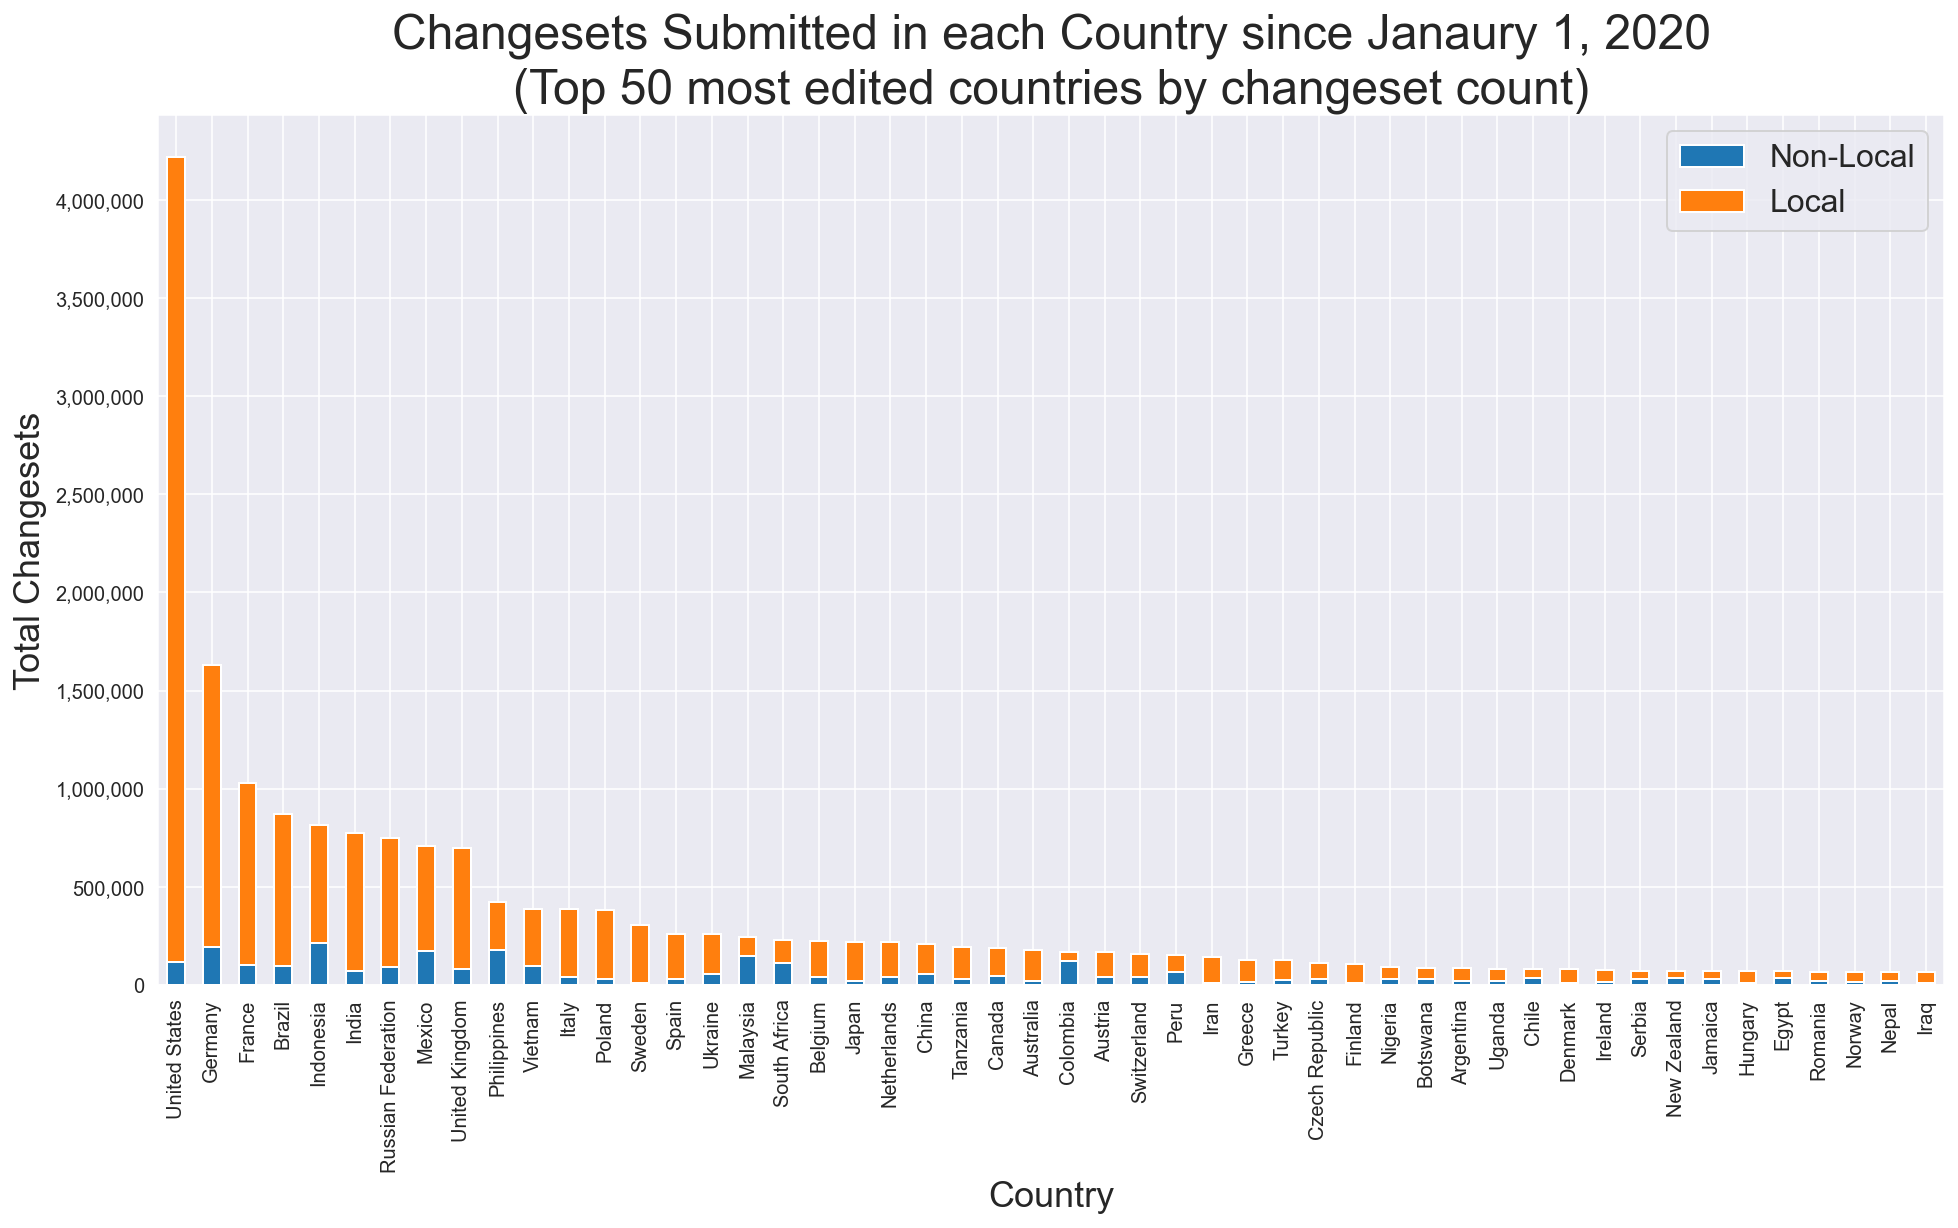

In [9]:
sns.set_style('darkgrid')
ax = gb_country.loc[country_order.head(50).country]['Changesets'].plot.bar(stacked=True, 
    figsize=(16,8))
ax.set_xlabel("Country", fontsize=18); ax.set_ylabel("Total Changesets", fontsize=18);
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.set_title("Changesets Submitted in each Country since Janaury 1, 2020\n(Top 50 most edited countries by changeset count)", fontsize=24);
ax.legend(fontsize=16);

## By actual _edit_ count from `num_changes` field

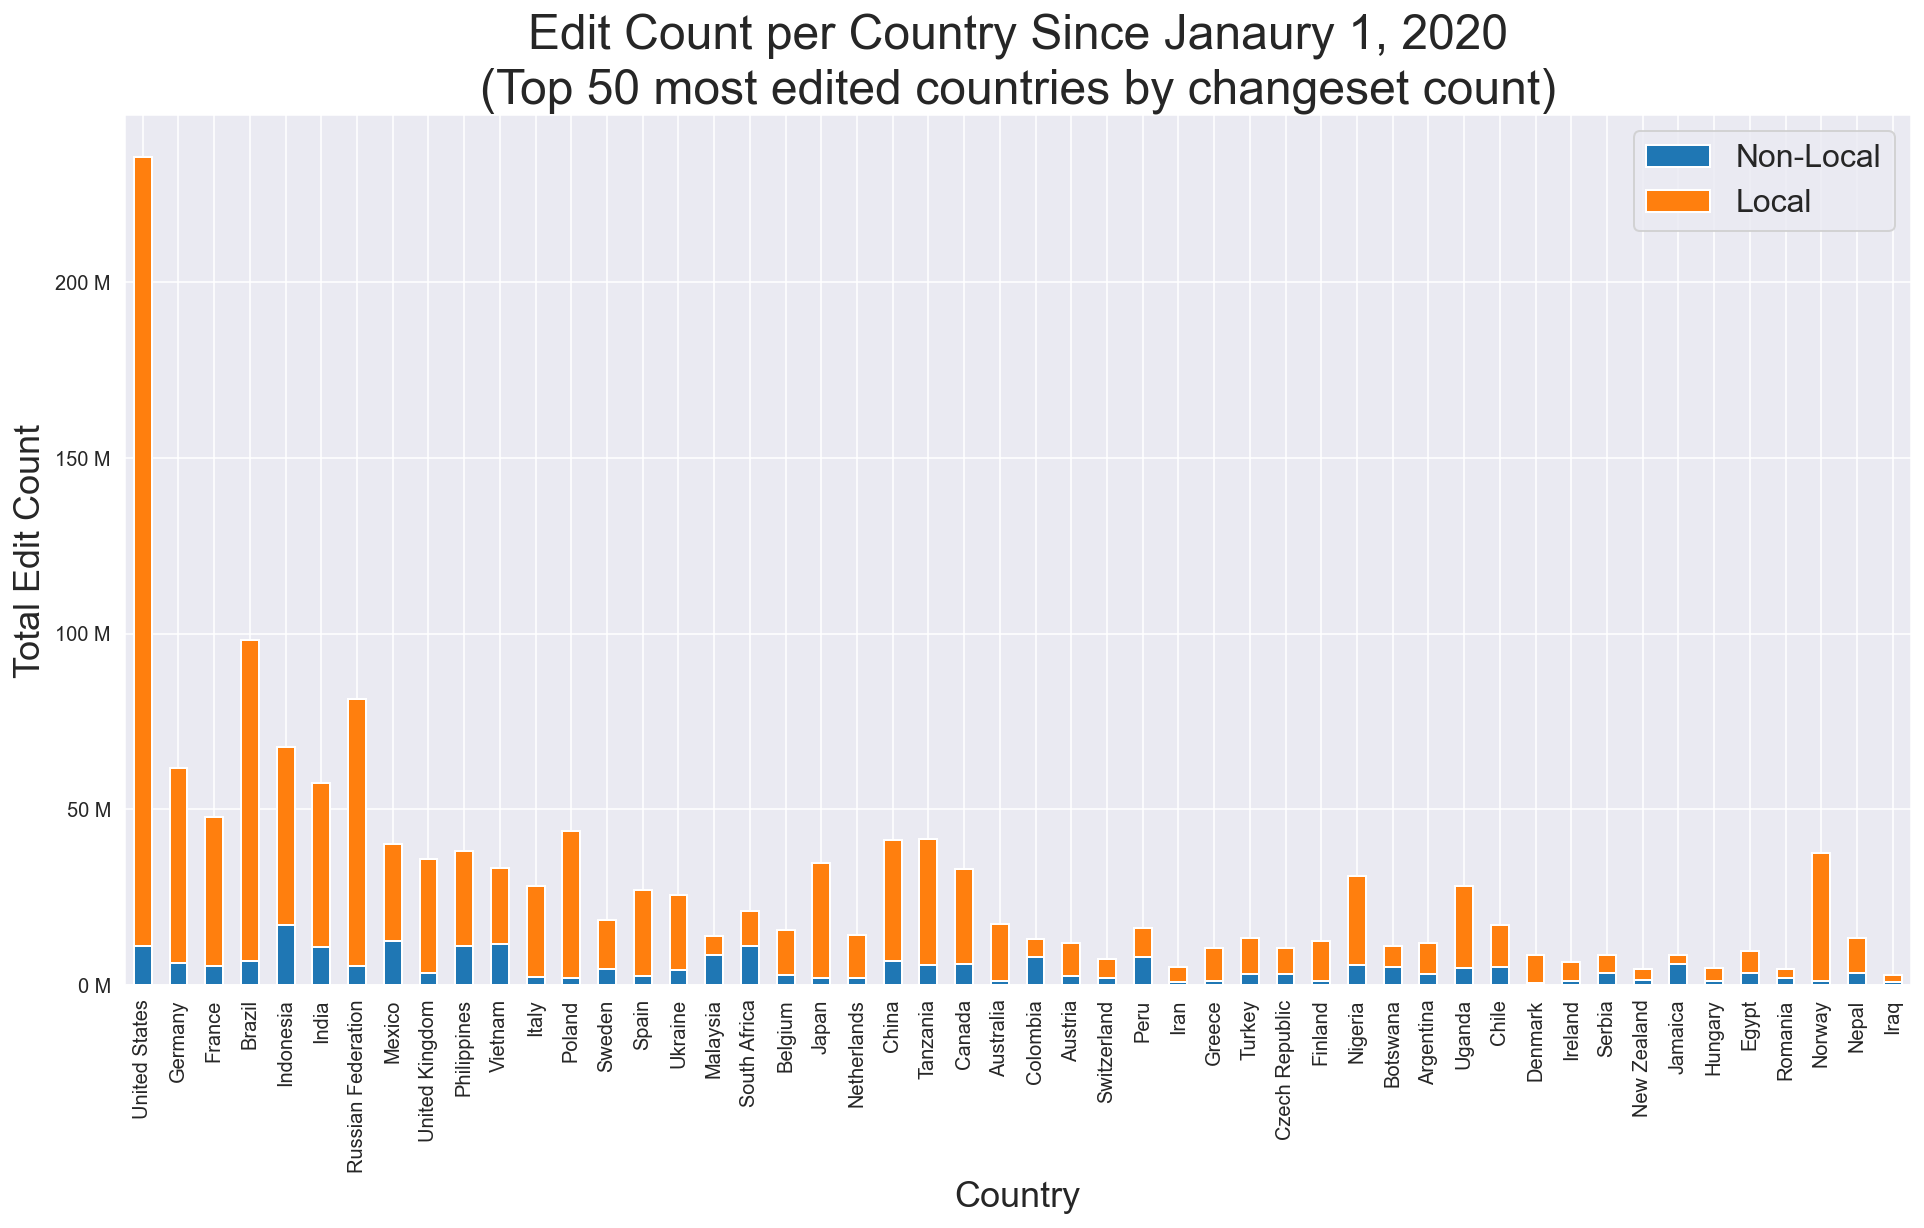

In [10]:
ax = gb_country.loc[country_order.head(50).country]['Edits'].plot.bar(stacked=True, figsize=(16,8))
ax.set_xlabel("Country", fontsize=18); ax.set_ylabel("Total Edit Count", fontsize=18);
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{} M".format(int(x/1000000))))
ax.set_title("Edit Count per Country Since Janaury 1, 2020\n(Top 50 most edited countries by changeset count)", fontsize=24);
ax.legend(fontsize=16);

# Aggregated by Mapper

Breaking down the _Total Mapper_ count by local/non-local mappers per Country

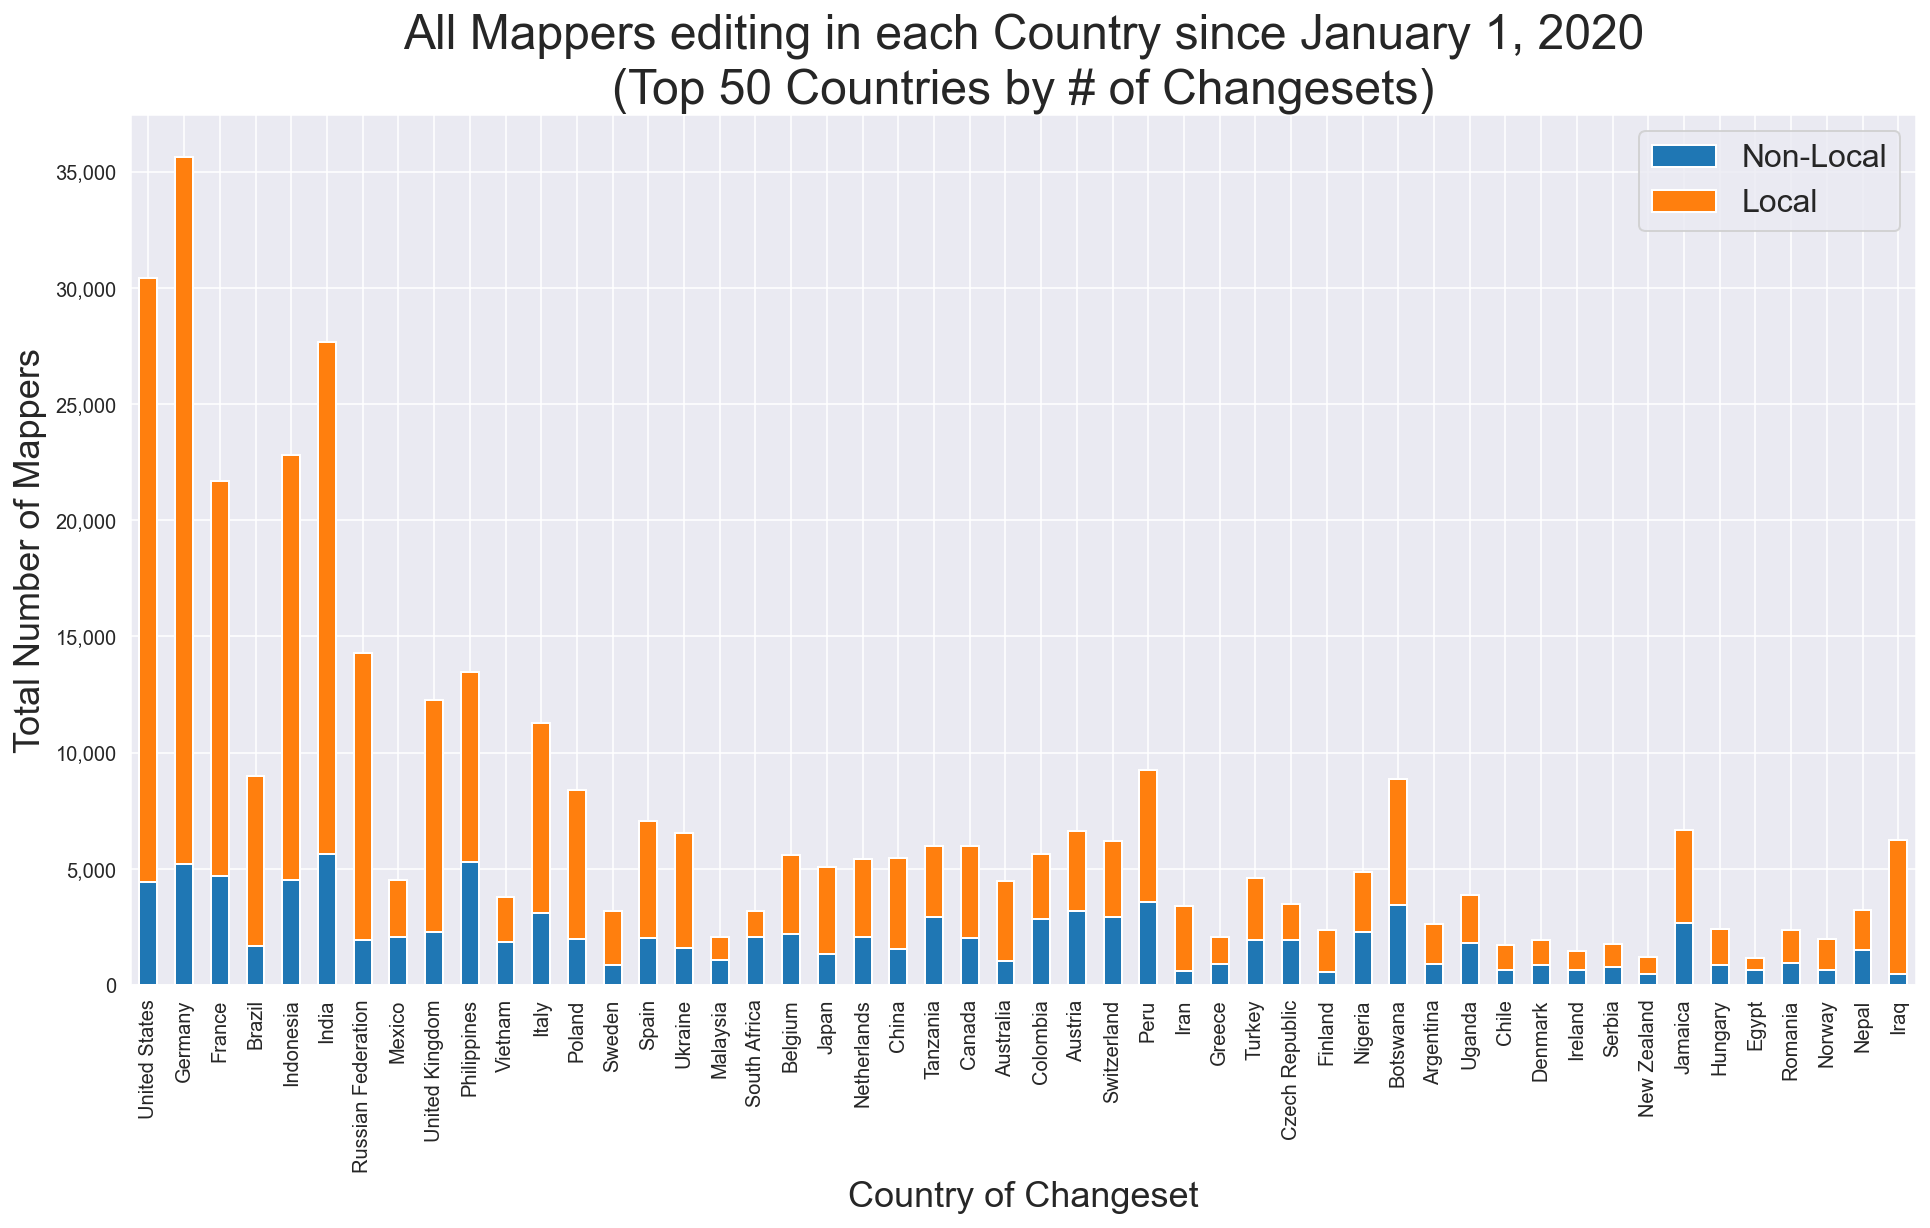

In [11]:
ax = gb_country.loc[country_order.head(50).country]['Users'].plot.bar(stacked=True, figsize=(16,8))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.set_xlabel("Country of Changeset", fontsize=18); ax.set_ylabel("Total Number of Mappers", fontsize=18);
ax.set_title("All Mappers editing in each Country since January 1, 2020\n(Top 50 Countries by # of Changesets)", fontsize=24);
ax.legend(fontsize=16);

These numbers are massively inflated by one-time contributors in OSM. For reference, in the last year, there have been over 170k mappers who edited only on 1 day. This likely isn't really enough information to determine a "local country" so these numbers are being inflated. 

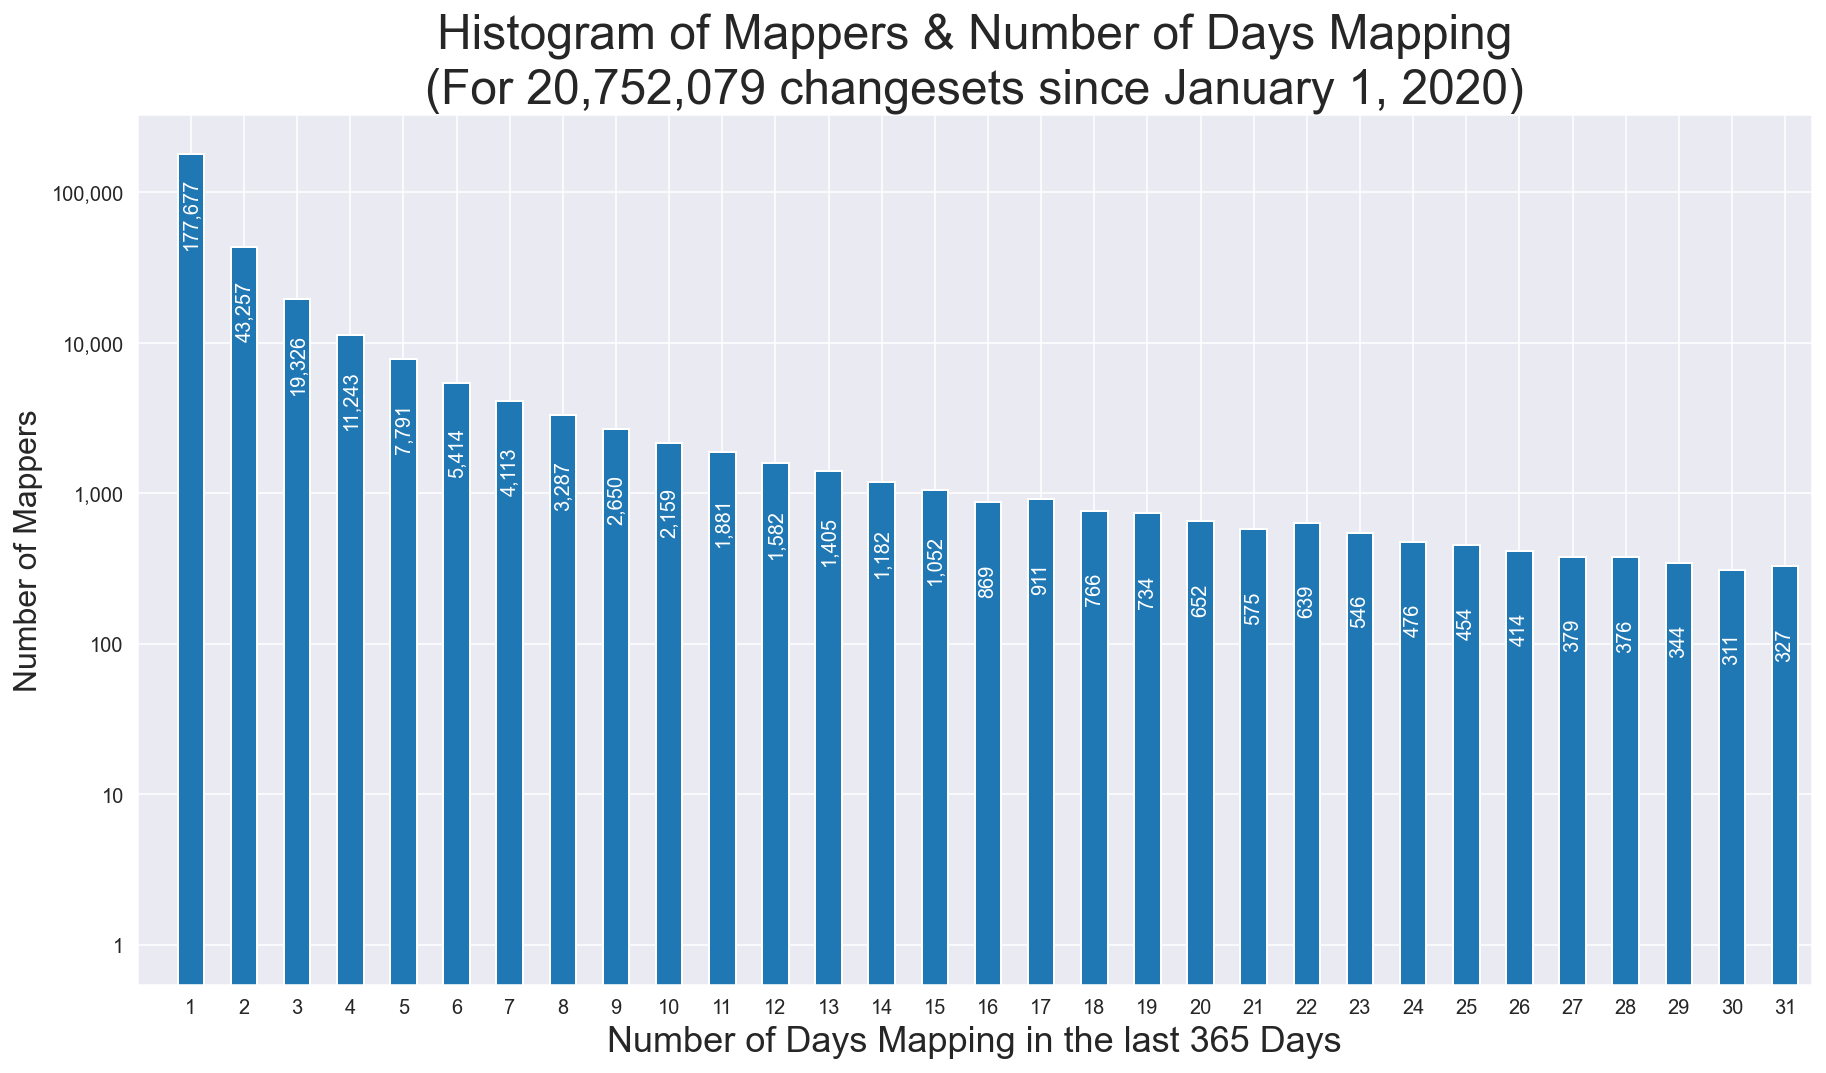

In [12]:
editing_days_hist = all_mappers.groupby('editing_days_in_last365').aggregate({'uid':'count'}).reset_index()
editing_days_hist.editing_days_in_last365 = editing_days_hist.editing_days_in_last365.astype(int)

ax = editing_days_hist.uid.plot.bar(figsize=(15,8), logy=True, legend=None);
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.set_xlim(-1,30.5)
ax.set_xlabel("Number of Days Mapping in the last 365 Days", fontsize=18); 
ax.set_ylabel("Number of Mappers", fontsize=16);
ax.set_xticklabels(editing_days_hist.editing_days_in_last365, rotation=0);

for index, value in enumerate(editing_days_hist.uid.head(31)):
    ax.text(index, 0.25*value, "{:,}".format(value), rotation=90, ha='center', va='baseline', color='white')

ax.set_title("Histogram of Mappers & Number of Days Mapping\n(For {:,} changesets since January 1, 2020)".format(len(changesets)), fontsize=24);

To adjust for this, let's look only at the number of mappers active for more than 2 days: 

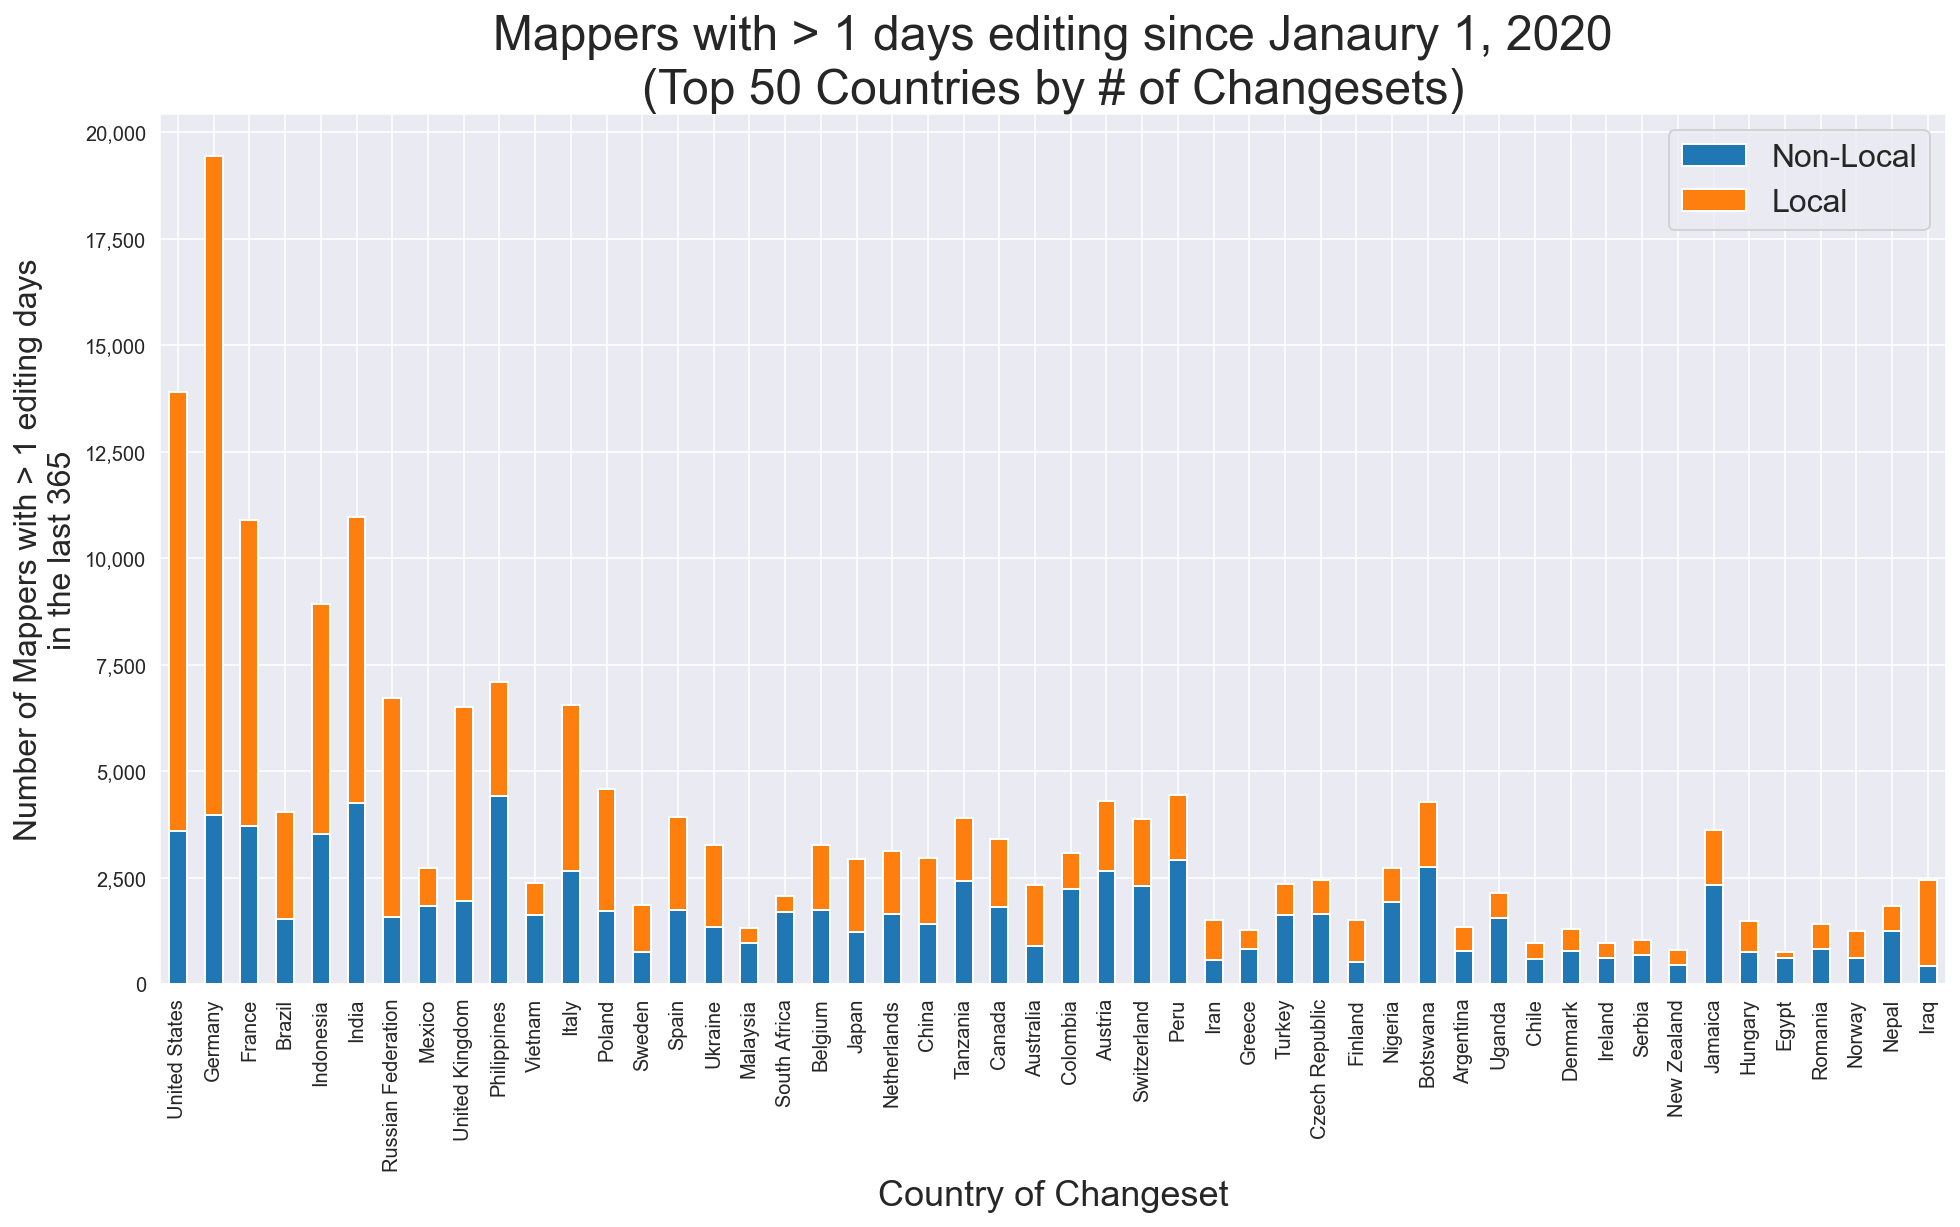

In [13]:
gb_country_gt1 = changesets[changesets.editing_days_in_last365>1].groupby(['country','is_local']).aggregate(
    {'uid':pd.Series.nunique,'id':'count','num_changes':sum}).unstack()
gb_country_gt1 = gb_country_gt1.rename(columns={False: 'Non-Local', True: 'Local'}, level=1
                     ).rename(columns={'uid': 'Users with > 1 day', 'id': 'Changesets from users with > 1 day', 'num_changes' : 'Editsfrom users with > 1 day'}, level=0)

ax = gb_country_gt1.loc[country_order.head(50).country]['Users with > 1 day'].plot.bar(stacked=True, figsize=(16,8))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.set_xlabel("Country of Changeset", fontsize=18); ax.set_ylabel("Total Number of Mappers", fontsize=18);
ax.legend(fontsize=16);

# ax = gb_country_local_gt2.loc[order].plot.bar(stacked=True, figsize=(16,8))
ax.set_xlabel("Country of Changeset", fontsize=18); ax.set_ylabel("Number of Mappers with > 1 editing days\nin the last 365", fontsize=16);
ax.set_title("Mappers with > 1 days editing since Janaury 1, 2020\n(Top 50 Countries by # of Changesets)", fontsize=24);
ax.legend(fontsize=16);

Notice the change in ratios of local / non-local mappers, partially given our loose definition of "local." Overall, many of the non-local mappers disappeared in this figure (notice the major decrease on the y-axis)

# Identifying the _Active Contributors_ active per Country?

In [14]:
gb_country_active = changesets.groupby(['country','is_active_contributor']).aggregate(
    {'uid':pd.Series.nunique,'id':'count','num_changes':sum}).unstack()
gb_country_active = gb_country_active.rename(columns={False: '< 42 Days', True: '>=42 Days\n("Active Contributors")'}, level=1
                     ).rename(columns={'uid': 'Users with >= 42 Days', 'id': 'Changesets from users with >= 42 days', 'num_changes': 'Edits from users with >= 42 days'}, level=0)

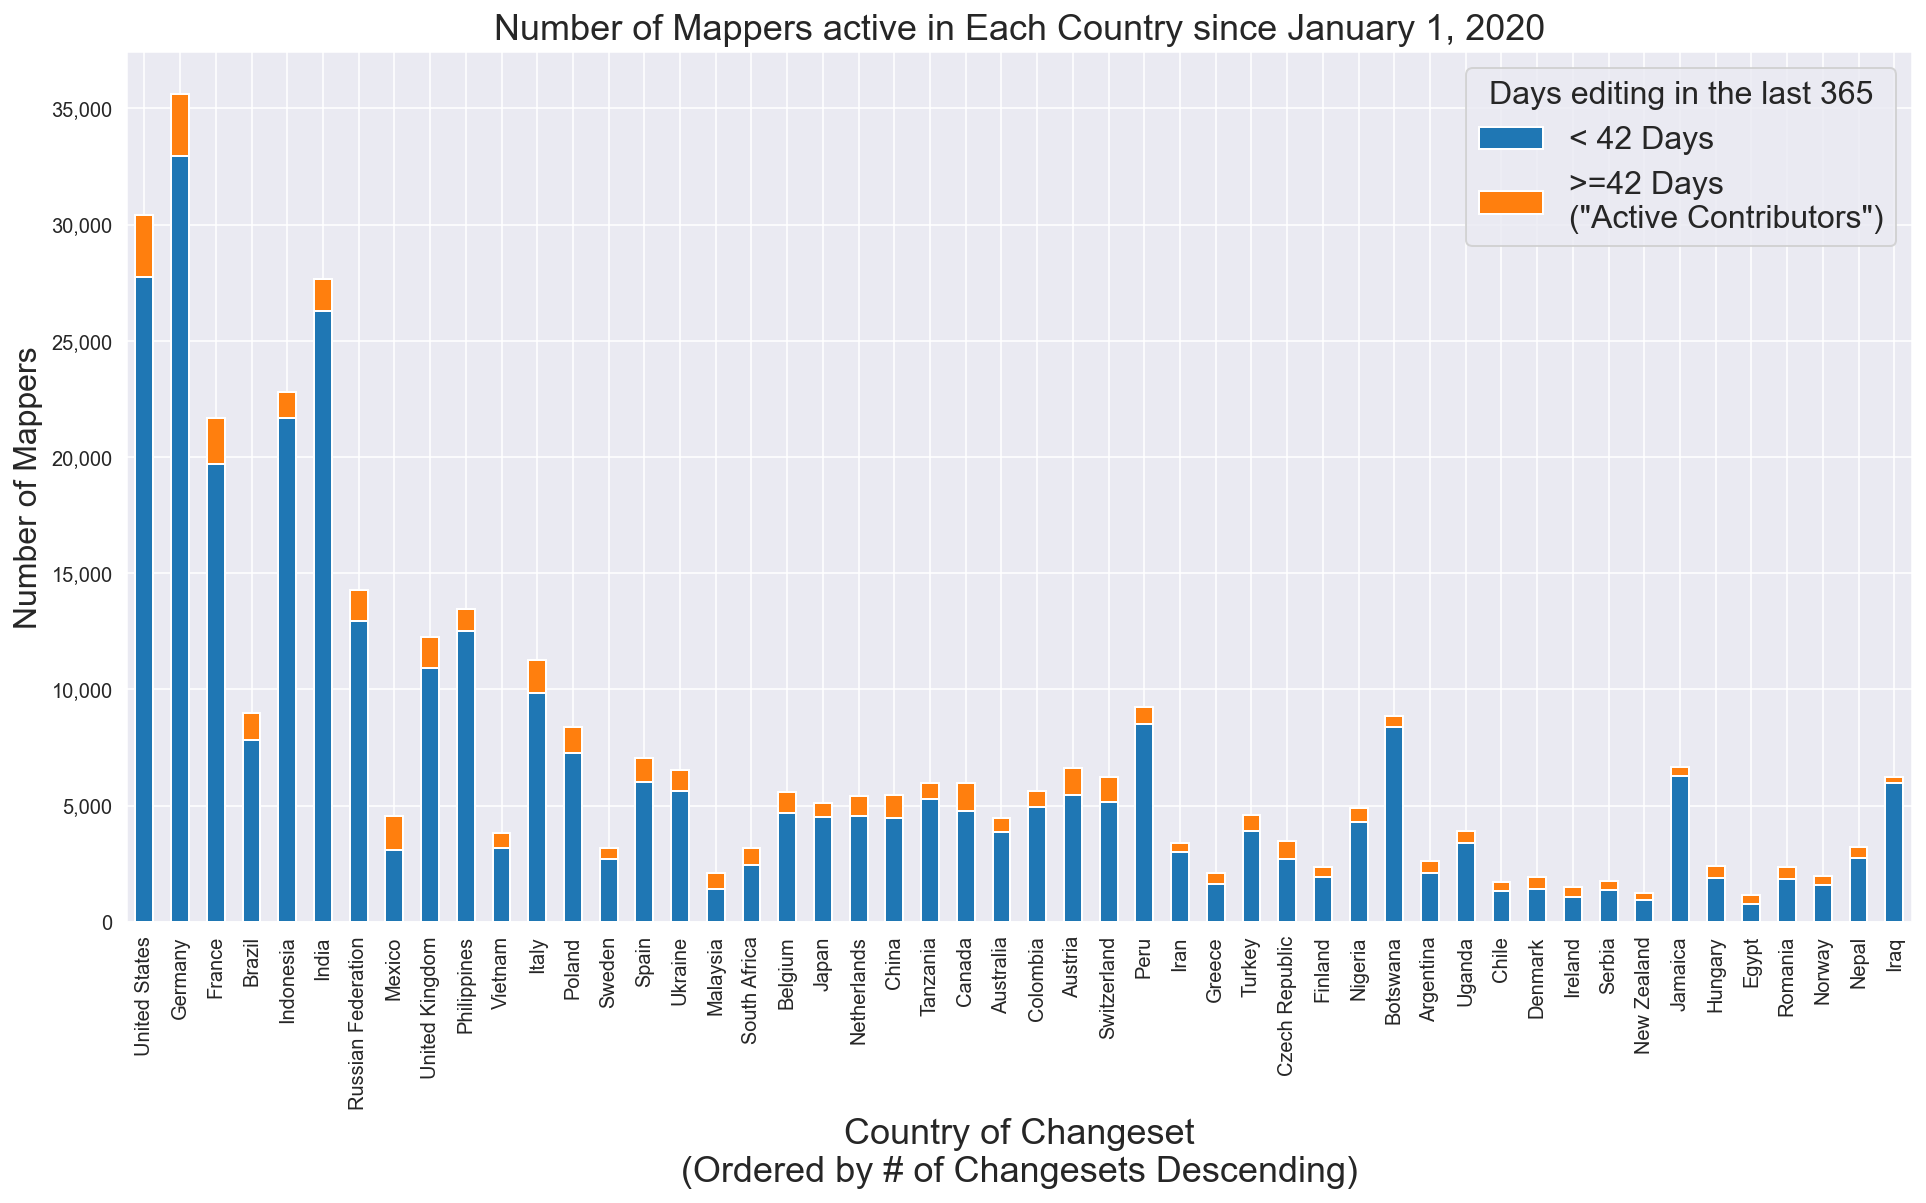

In [15]:
ax = gb_country_active.loc[country_order.head(50).country]['Users with >= 42 Days'].plot.bar(stacked=True, figsize=(16,8));
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.legend(title="Days editing in the last 365", fontsize=16, title_fontsize=16)
ax.set_ylabel("Number of Mappers", fontsize=16); ax.set_xlabel("Country of Changeset\n(Ordered by # of Changesets Descending)", fontsize=18);
ax.set_title("Number of Mappers active in Each Country since January 1, 2020", fontsize=18);

## Save Per-Country Results as Table

In [16]:
as_table = gb_country.join(gb_country_gt1).join(gb_country_active)
as_table.to_csv('./data/country_editing_stats_since_2020.csv')
as_table

Users         Changesets                 Edits  \
is_local          Non-Local   Local  Non-Local     Local   Non-Local   
country                                                                
Afghanistan           386.0   116.0    13447.0   18539.0   2105091.0   
Albania               407.0   158.0     7159.0    2380.0    911550.0   
Algeria               468.0   786.0     6926.0   30235.0    907017.0   
American Samoa         28.0     NaN      111.0       NaN     14205.0   
Andorra               159.0    13.0      645.0      23.0     48851.0   
...                     ...     ...        ...       ...         ...   
Vietnam              1833.0  1976.0    96442.0  292681.0  11723454.0   
Wallis and Futuna      14.0     1.0       30.0       4.0      6316.0   
Yemen                1000.0   724.0     9471.0    7919.0   1227378.0   
Zambia                708.0  2420.0     8165.0   30856.0   1781154.0   
Zimbabwe              908.0   312.0     7131.0    3523.0    949885.0   

                              Users with > 1 day         \
is_local                Local          Non-Local  Local   
country                                                   
Afghanistan         4776650.0              365.0   52.0   
Albania              319768.0              366.0   46.0   
Algeria             1654839.0              438.0  264.0   
American Samoa            NaN               28.0    NaN   
Andorra                 147.0              140.0    2.0   
...                       ...                ...    ...   
Vietnam            21559449.0             1615.0  754.0   
Wallis and Futuna         5.0               14.0    NaN   
Yemen                592599.0              879.0  247.0   
Zambia              8682175.0              623.0  416.0   
Zimbabwe             840198.0              606.0   78.0   

                  Changesets from users with > 1 day            \
is_local                                   Non-Local     Local   
country                                                          
Afghanistan                                  13419.0   18142.0   
Albania                                       7063.0    2184.0   
Algeria                                       6862.0   29121.0   
American Samoa                                 111.0       NaN   
Andorra                                        609.0       6.0   
...                                              ...       ...   
Vietnam                                      95783.0  287173.0   
Wallis and Futuna                               30.0       NaN   
Yemen                                         9198.0    6591.0   
Zambia                                        7981.0   19266.0   
Zimbabwe                                      5873.0    2724.0   

                  Editsfrom users with > 1 day              \
is_local                             Non-Local       Local   
country                                                      
Afghanistan                          2104525.0   4770417.0   
Albania                               905443.0    314729.0   
Algeria                               904955.0   1637996.0   
American Samoa                         14205.0         NaN   
Andorra                                48208.0        17.0   
...                                        ...         ...   
Vietnam                             11666182.0  21350557.0   
Wallis and Futuna                       6316.0         NaN   
Yemen                                1196703.0    504611.0   
Zambia                               1763968.0   8219646.0   
Zimbabwe                              817240.0    793204.0   

                  Users with >= 42 Days                                     \
is_local                      < 42 Days >=42 Days\n("Active Contributors")   
country                                                                      
Afghanistan                       251.0                              251.0   
Albania                           345.0                              220.0   
Al

# Finally, Active Contributors per Country?

In [17]:
all_mappers = all_mappers.rename(columns={'most_edited_country':'code'}
                  ).merge(changesets.drop_duplicates(subset='code')[['country','code']].reset_index(drop=True))
all_mappers.head()

,uid,user,code,editing_days_in_last365,total_edits_in_last365,is_active_contributor,changesets_in_last365,country
0,3703299,ct12543,US,3.0,92.0,False,4.0,United States
1,12254628,Wild Spike,US,31.0,14283.0,False,182.0,United States
2,86565,ricomundy,US,22.0,3836.0,False,73.0,United States
3,624084,MarksPhotoTrips,US,167.0,22729.0,True,562.0,United States
4,187467,Mashin,US,223.0,223370.0,True,1096.0,United States


In [18]:
gb_home_country_active = all_mappers.groupby(['country','is_active_contributor']).aggregate(
    {'uid':pd.Series.nunique}).unstack()

gb_home_country_active = gb_home_country_active.rename(columns={False: '< 42 Days', True: '>=42 Days\n("Active Contributors")'}, level=1
                     ).rename(columns={'uid': 'Users with >= 42 Days', 'id': 'Changesets from users with >= 42 days', 'num_changes': 'Edits from users with >= 42 days'}, level=0)

gb_home_country_active.head()

Users with >= 42 Days                                   
is_active_contributor             < 42 Days >=42 Days\n("Active Contributors")
country                                                                       
Afghanistan                           109.0                               12.0
Albania                               167.0                                4.0
Algeria                               788.0                               19.0
American Samoa                          2.0                                NaN
Andorra                                13.0                                NaN

In [19]:
user_order = all_mappers.groupby('country').aggregate(
    {'uid':'count'}).sort_values(by='uid', ascending=False).reset_index().country

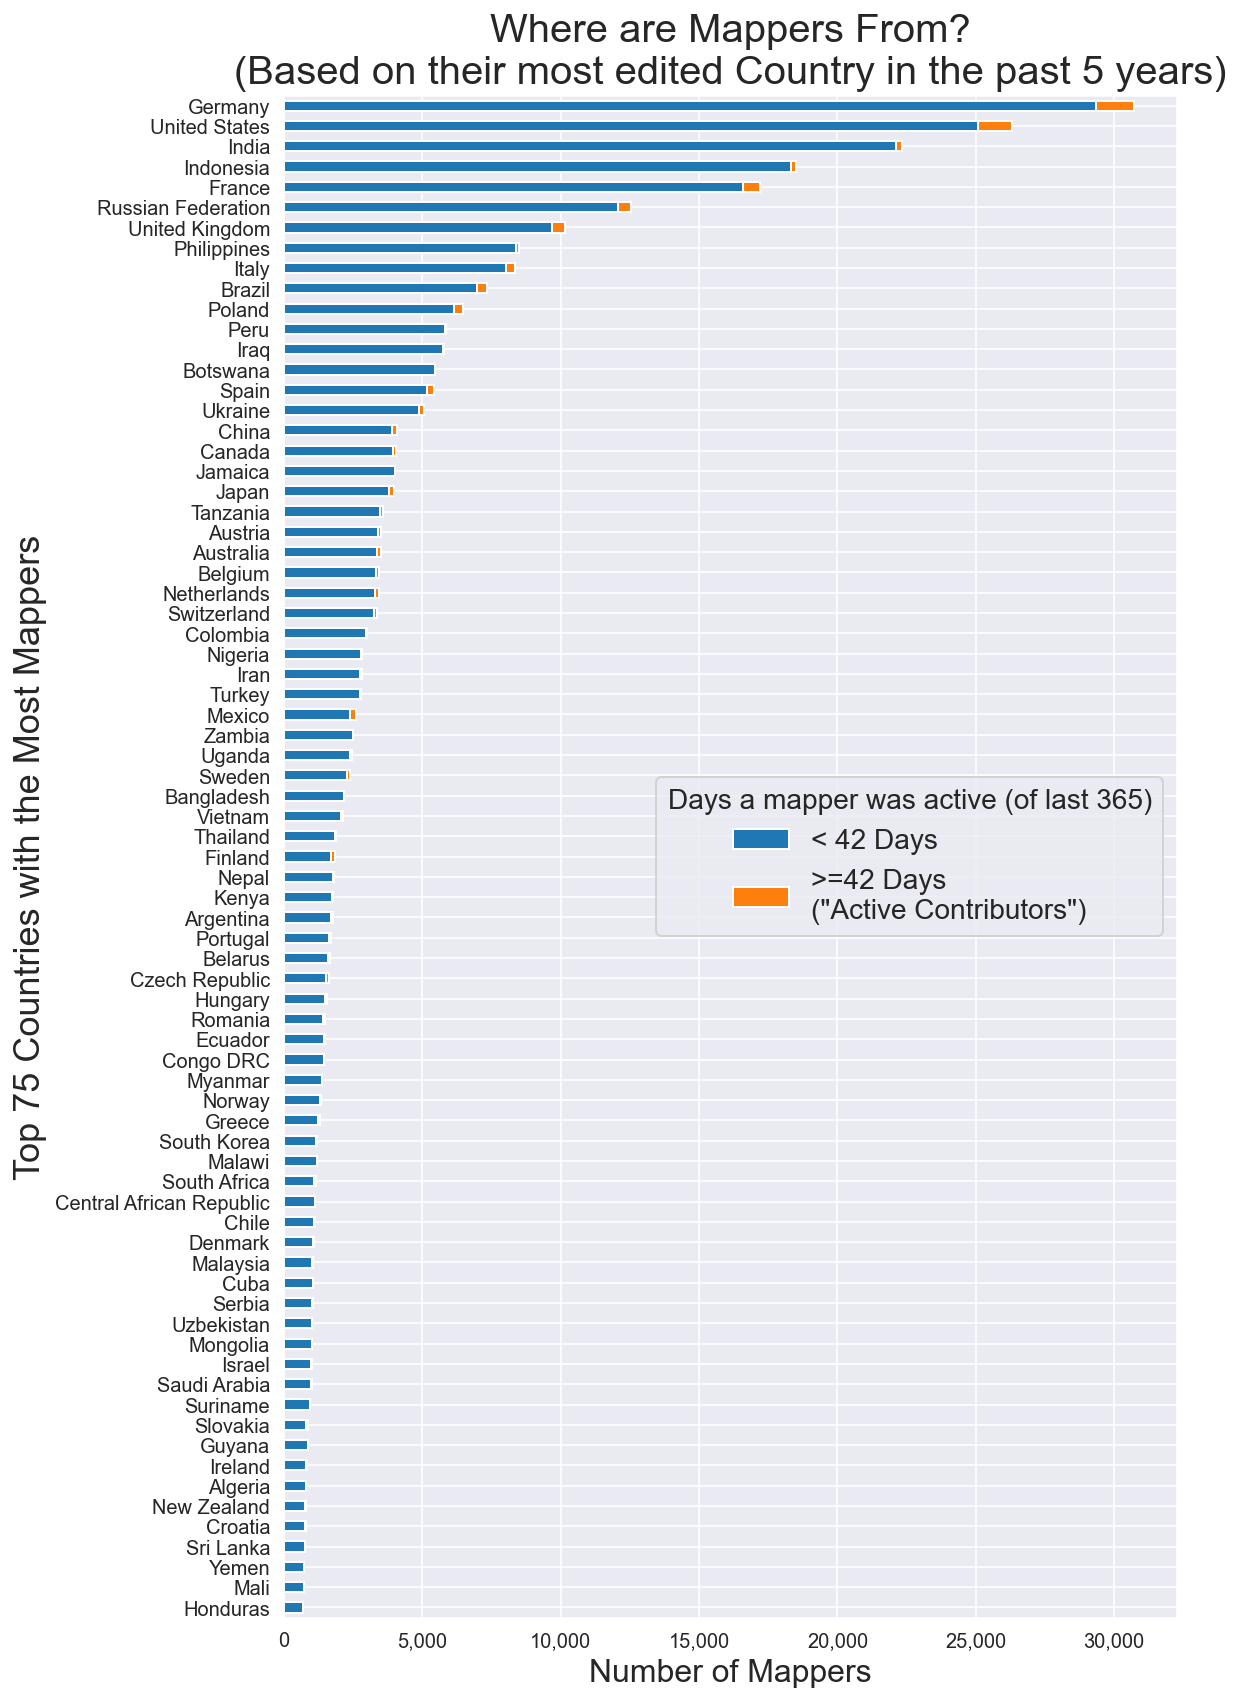

In [20]:
ax = gb_home_country_active.loc[user_order.head(75)]['Users with >= 42 Days'].plot.barh(stacked=True, figsize=(8,14));
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.legend(fontsize=14, loc='center right', title="Days a mapper was active (of last 365)", title_fontsize=14)
ax.invert_yaxis()
ax.set_xlabel("Number of Mappers", fontsize=16); 
ax.set_ylabel("Top 75 Countries with the Most Mappers", fontsize=18);
ax.set_title("Where are Mappers From?\n(Based on their most edited Country in the past 5 years)", fontsize=20);

In [21]:
all_mappers['1']      = all_mappers.editing_days_in_last365.apply(lambda x: x < 2)
all_mappers['2-5']    = all_mappers.editing_days_in_last365.apply(lambda x: x >= 2 and x < 6)
all_mappers['6-19']   = all_mappers.editing_days_in_last365.apply(lambda x: x >= 6 and x < 20)
all_mappers['20-41']  = all_mappers.editing_days_in_last365.apply(lambda x: x >= 20 and x < 41)
all_mappers['42-99'] = all_mappers.editing_days_in_last365.apply(lambda x: x >= 42 and x < 100)
all_mappers['100-199']= all_mappers.editing_days_in_last365.apply(lambda x: x >= 100 and x < 200)
all_mappers['200+']= all_mappers.editing_days_in_last365.apply(lambda x: x >= 200)

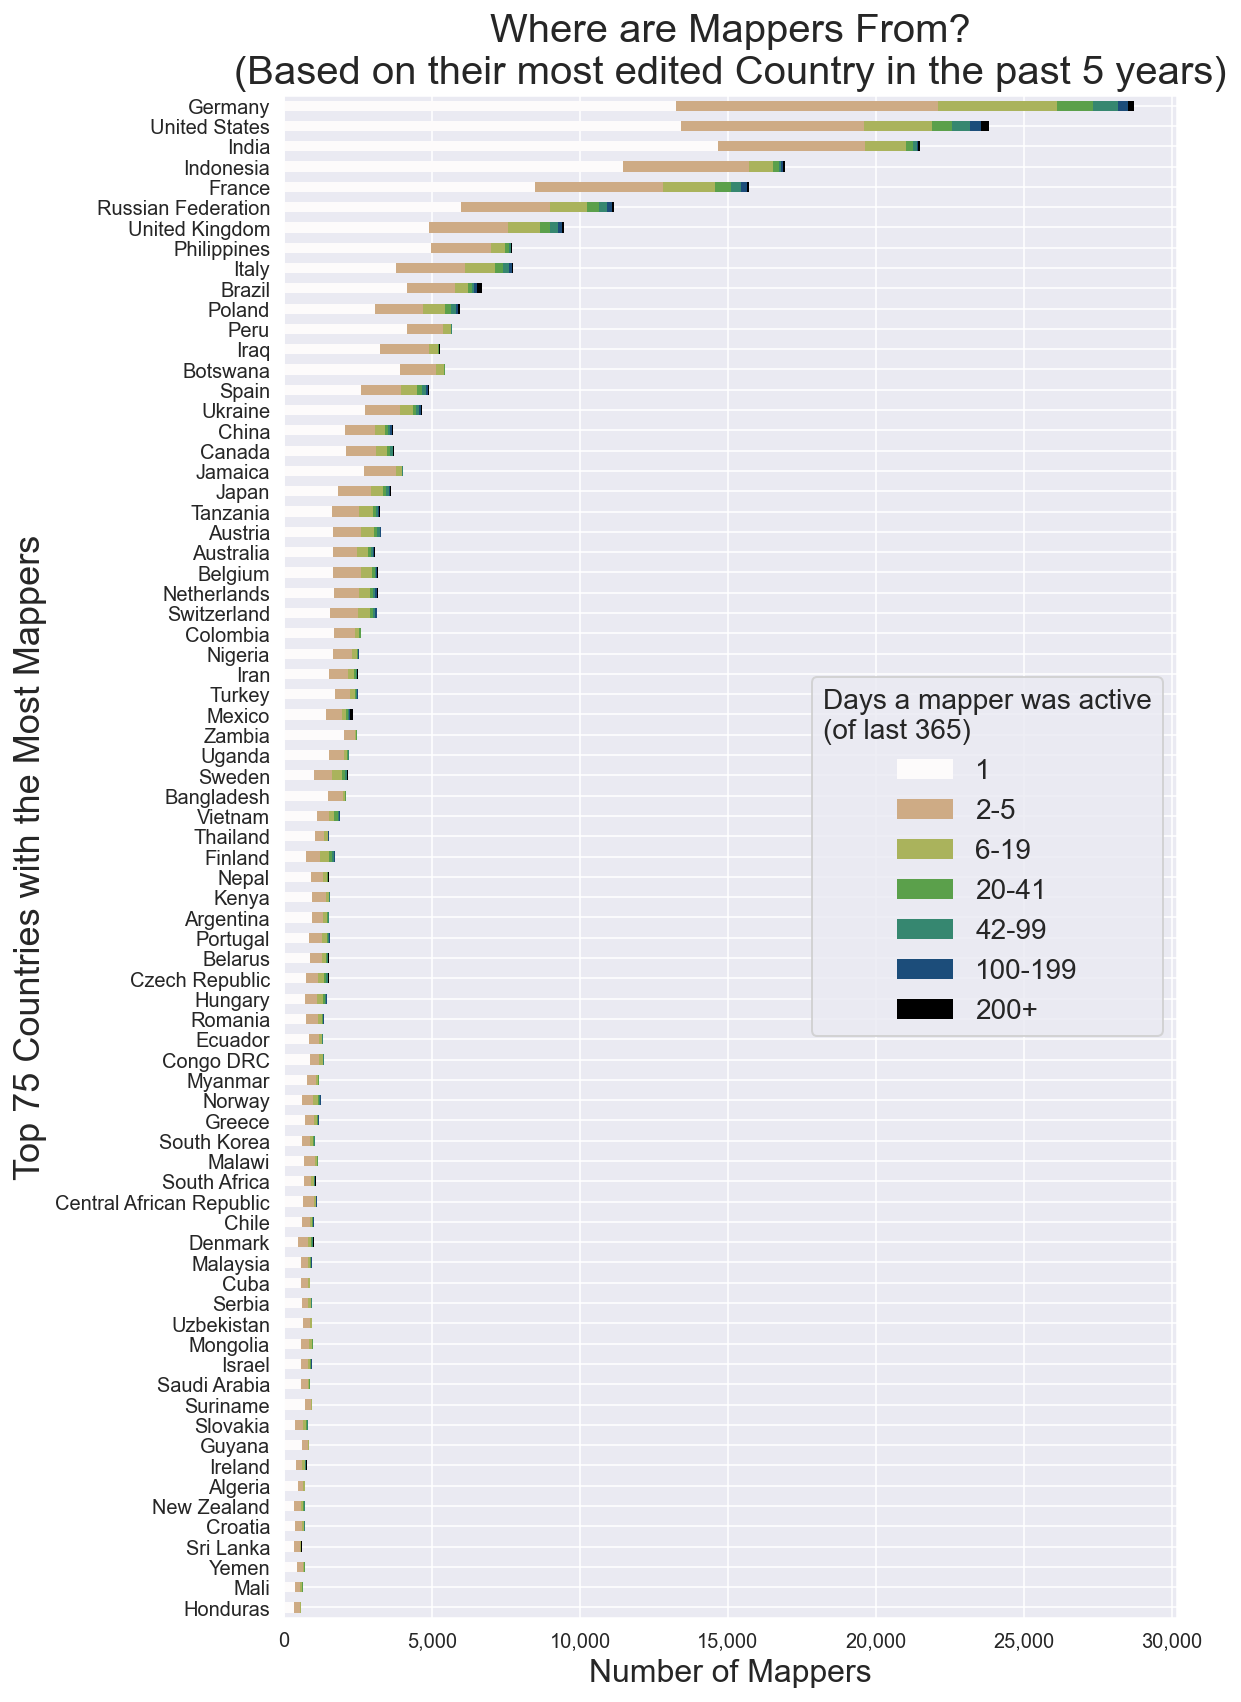

In [24]:
ax = all_mappers.groupby('country').aggregate('sum').loc[user_order.head(75)][
    ['1','2-5','6-19','20-41','42-99','100-199','200+']
].plot.barh(
    stacked=True, figsize=(8,14), cmap=sns.color_palette('gist_earth_r', as_cmap=True), linewidth=0);
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.legend(fontsize=14, loc='center right', title="Days a mapper was active\n(of last 365)", title_fontsize=14)
ax.invert_yaxis()
# ax.legend([])
ax.set_xlabel("Number of Mappers", fontsize=16); 
ax.set_ylabel("Top 75 Countries with the Most Mappers", fontsize=18);
ax.set_title("Where are Mappers From?\n(Based on their most edited Country in the past 5 years)", fontsize=20);